In [152]:
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt

from sciterra.mapping.atlas import Atlas
from sciterra.mapping.cartography import Cartographer
from sciterra.vectorization.scibert import SciBERTVectorizer

In [153]:
atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-10-23_centered_hafenetal"

In [154]:
atl = Atlas.load(atlas_dir)

In [155]:
atl.history.keys()

dict_keys(['pubs_per_update', 'kernel_size'])

In [156]:
kernels = atl.history['kernel_size']
kernels.shape

(10127, 21)

In [157]:
convergence_degrees = list(range(kernels.shape[1])) # the max convergence iteration
# adding 1 because '0' con_d is weird, does not follow the monotonically decreasing relationship of pubs w conv degree


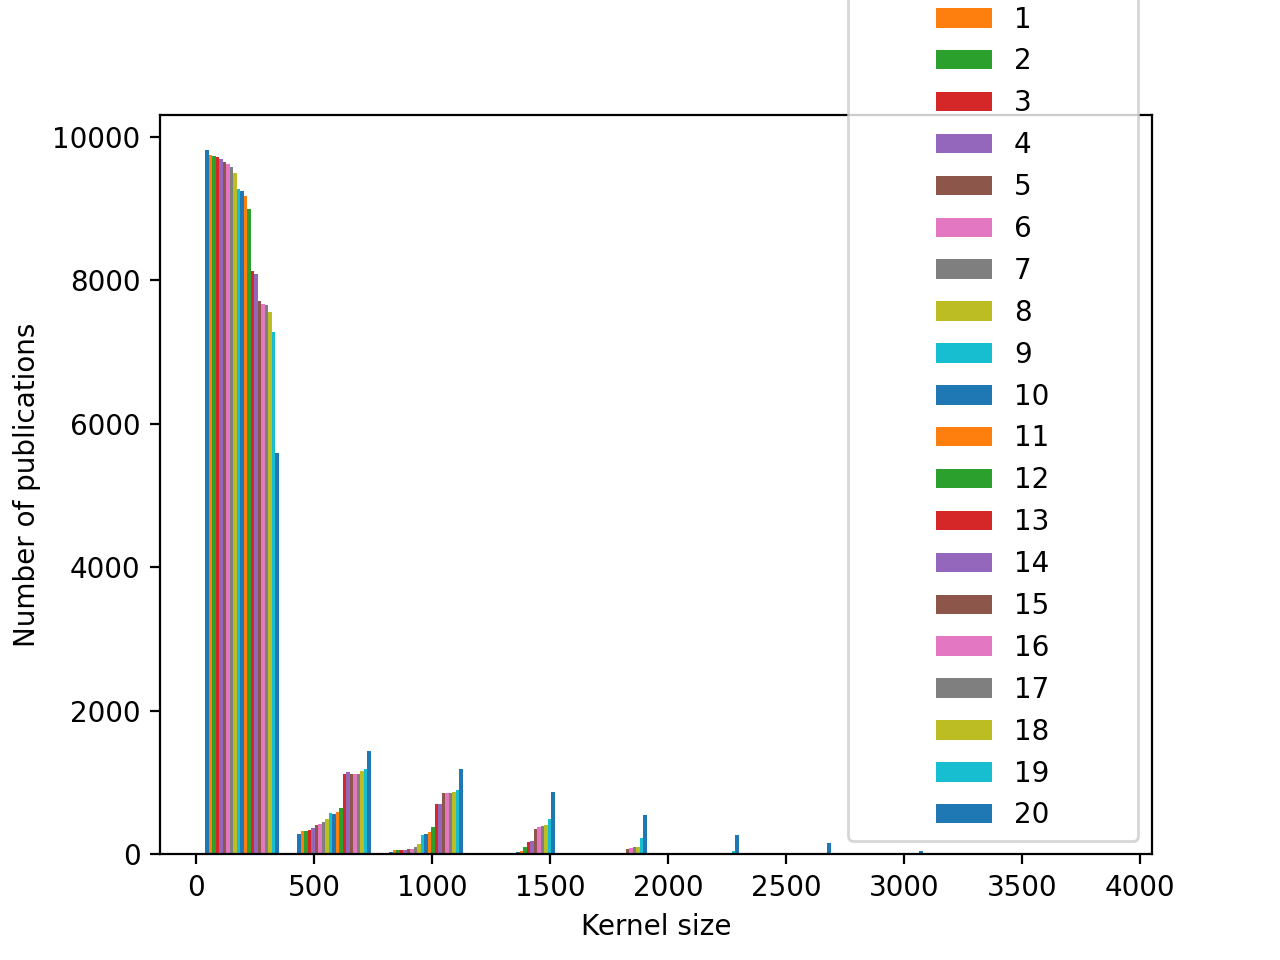

In [158]:
# plt.hist(x=kernels)

plt.hist(kernels, label=range(kernels.shape[1]))
 
plt.xlabel('Kernel size')
plt.ylabel('Number of publications')
plt.legend(
    title = 'expansion iteration',
)
plt.show()

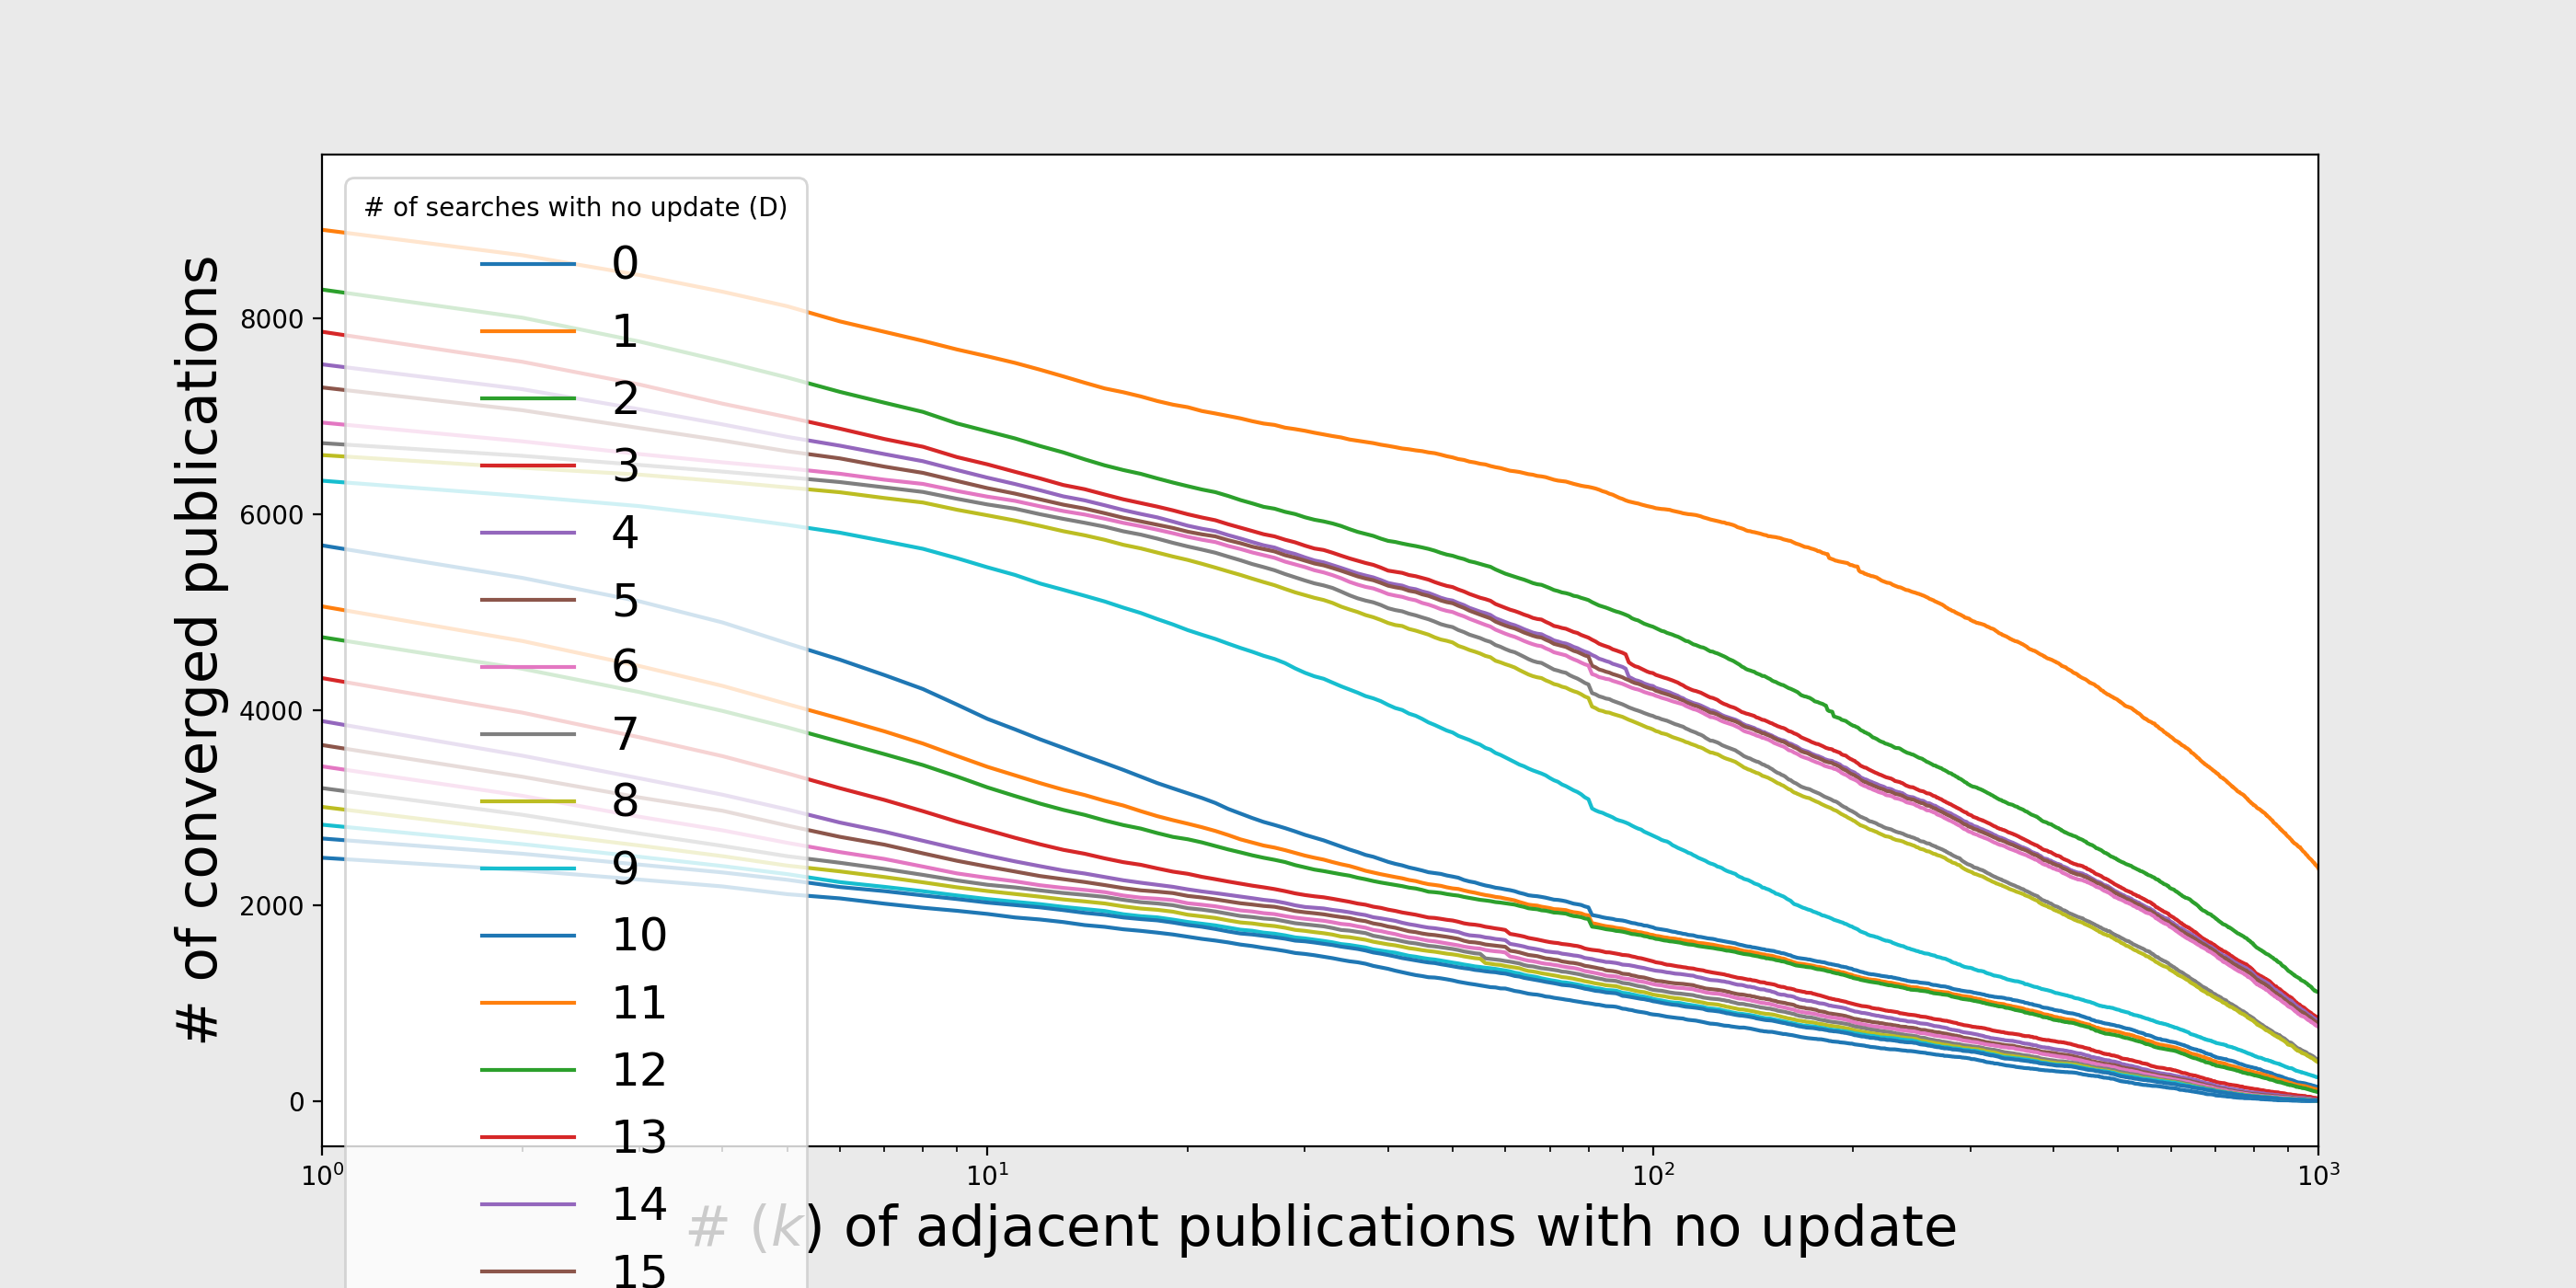

In [159]:
fig = plt.figure( figsize=(14,7), facecolor=np.array([ 235, 235, 235 ]) / 256. )
ax = plt.gca()

n_total = 0
n_all = 0
n_samples = []

bins = np.arange( -0.5, kernels.max()+1.5, 1. )

for i, con_d in enumerate( convergence_degrees ):

    # Calculate the distribution of kernel sizes
    hist, bins = np.histogram(
        kernels[:,-con_d], # the largest kernel size that hasn't changed since the 3rd to last update, i.e. after 7 updates
        bins = bins,
    )
    centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

    # Calculate the number of publications with that kernel size or more
    cumulative = np.cumsum( hist )
    reverse_cumulative = ( cumulative[-1] - cumulative )
    
    ax.plot(
        centers,
        reverse_cumulative,
        label = con_d,
    )

ax.set_xlim( 1, 1e3, )
# ax.set_ylim( 0, 15000 )
ax.set_xscale( 'log' )

ax.set_xlabel( r'# $(k)$ of adjacent publications with no update', fontsize=22 )
ax.set_ylabel( '# of converged publications', fontsize=22 )
ax.legend(
    prop={'size':18 },
    title = '# of searches with no update (D)',
)

# # Save
# save_fp = 'converged_kernel_size.pdf'
# fig.savefig( save_fp, bbox_inches='tight' )
# print( 'Saved at {}'.format( save_fp ) )

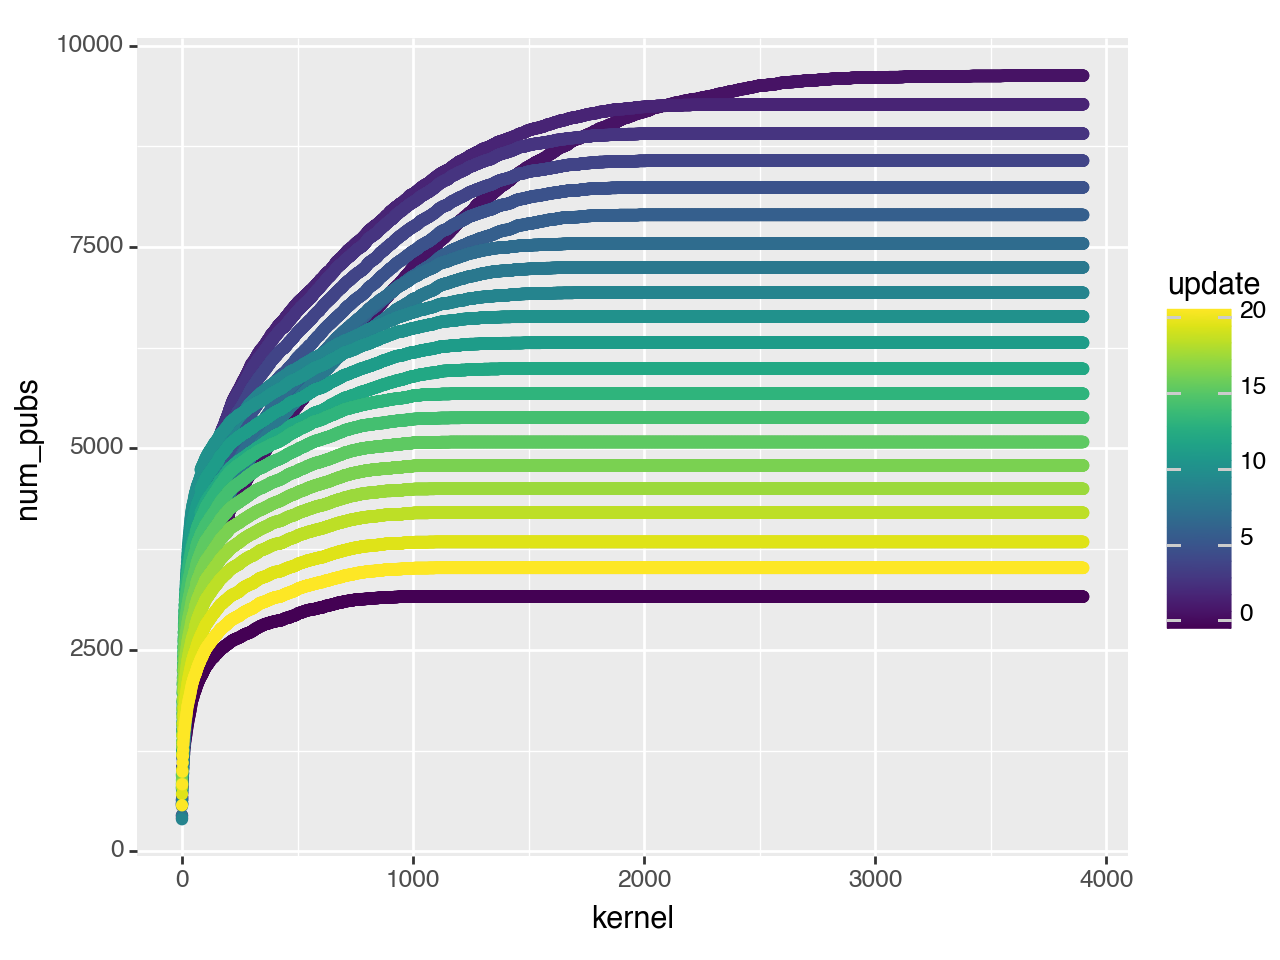

<Figure Size: (640 x 480)>

In [160]:

dfs = []
for i, con_d in enumerate( convergence_degrees ):

    # Calculate the distribution of kernel sizes
    hist, bins = np.histogram(
        kernels[:,-con_d], # the largest kernel size that hasn't changed since the 3rd to last update, i.e. after 7 updates
        bins = bins,
    )
    centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

    # Calculate the number of publications with that kernel size or more
    cumulative = np.cumsum( hist )
    reverse_cumulative = ( cumulative[-1] - cumulative )

    df = pd.DataFrame(data=zip(centers, cumulative, [con_d]*len(centers)), columns=["kernel", "num_pubs", "update"])
    dfs.append(df)

df = pd.concat(dfs)


(
    pn.ggplot(df, pn.aes(x="kernel", y="num_pubs", color="update"))
    + pn.geom_point()
)


## Filter atlas by converged publications

In [161]:
# converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
# converged = converged_kernel_size >= pm['kernel_size']
# publications = c.publications[converged]
# inds = np.arange( c.publications.size )[converged]

In [169]:
con_d = 1
kernel_size = 100
converged_filter = kernels[:, -con_d] >= kernel_size
ids = np.array(atl.projection.index_to_identifier)
converged_pub_ids = ids[converged_filter]

[atl[id].title for id in converged_pub_ids][:10]

['Low-redshift Lyman limit systems as diagnostics of cosmological inflows and outflows',
 'DISSECTING THE PROPERTIES OF OPTICALLY THICK HYDROGEN AT THE PEAK OF COSMIC STAR FORMATION HISTORY',
 'Key Physical Processes in the Circumgalactic Medium',
 'The baryonic assembly of dark matter haloes',
 'On the evolution of the H i column density distribution in cosmological simulations',
 'Observational signatures of a warped disk associated with cold-flow accretion',
 'The Bimodal Absorption System Imaging Campaign (BASIC). I. A Dual Population of Low-metallicity Absorbers at z < 1',
 'Warm-hot gas in X-ray bright galaxy clusters and the H I-deficient circumgalactic medium in dense environments',
 'A general class of Lagrangian smoothed particle hydrodynamics methods and implications for fluid mixing problems',
 'Detection of Pristine Gas Two Billion Years After the Big Bang']

### measure topography of converged pubs


In [170]:
crt = Cartographer(vectorizer=SciBERTVectorizer())

Using device: cpu.


In [171]:
measurements = crt.measure_topography(
    atl, 
    ids=converged_pub_ids,
    metrics=["density", "edginess"], 
    kernel_size=kernel_size,
)

computing cosine similarity for 6076 embeddings with batch size 1000.


100%|██████████| 7/7 [00:00<00:00, 19.35it/s]


Computing ['density', 'edginess'] for 6076 publications.


invalid value encountered in divide


In [175]:
# get citations
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in converged_pub_ids
]
# what if we just drop all those with 0 citations (per year)?
# and those > 100 anyway
citations_per_year = [item if (item > 0. and item < 100.) else None for item in citations_per_year ]
citations_per_year

[8.857142857142858,
 7.2,
 None,
 17.833333333333332,
 27.454545454545453,
 5.333333333333333,
 3.0,
 5.166666666666667,
 29.454545454545453,
 11.333333333333334,
 6.875,
 6.5,
 29.0,
 1.5,
 10.583333333333334,
 12.285714285714286,
 92.6,
 10.6,
 48.5,
 2.0588235294117645,
 10.75,
 20.416666666666668,
 27.285714285714285,
 22.217391304347824,
 1.2,
 5.357142857142857,
 1.0,
 None,
 28.571428571428573,
 62.421052631578945,
 5.2,
 11.428571428571429,
 2.1666666666666665,
 2.0,
 14.25,
 3.6666666666666665,
 11.0,
 6.25,
 1.1666666666666667,
 21.357142857142858,
 3.75,
 5.0,
 6.5,
 3.6,
 30.125,
 7.666666666666667,
 2.6,
 4.0,
 0.75,
 5.416666666666667,
 1.25,
 9.733333333333333,
 13.333333333333334,
 8.714285714285714,
 17.692307692307693,
 2.0,
 27.823529411764707,
 15.625,
 16.90909090909091,
 1.0,
 5.846153846153846,
 6.285714285714286,
 None,
 11.692307692307692,
 11.5,
 1.6666666666666667,
 17.066666666666666,
 27.94736842105263,
 6.0,
 56.65,
 3.3333333333333335,
 7.538461538461538,

In [176]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True) # not sure why this didn't take care of later NaNs
df.to_csv("stuff.csv")

geom_point : Removed 897 rows containing missing values.


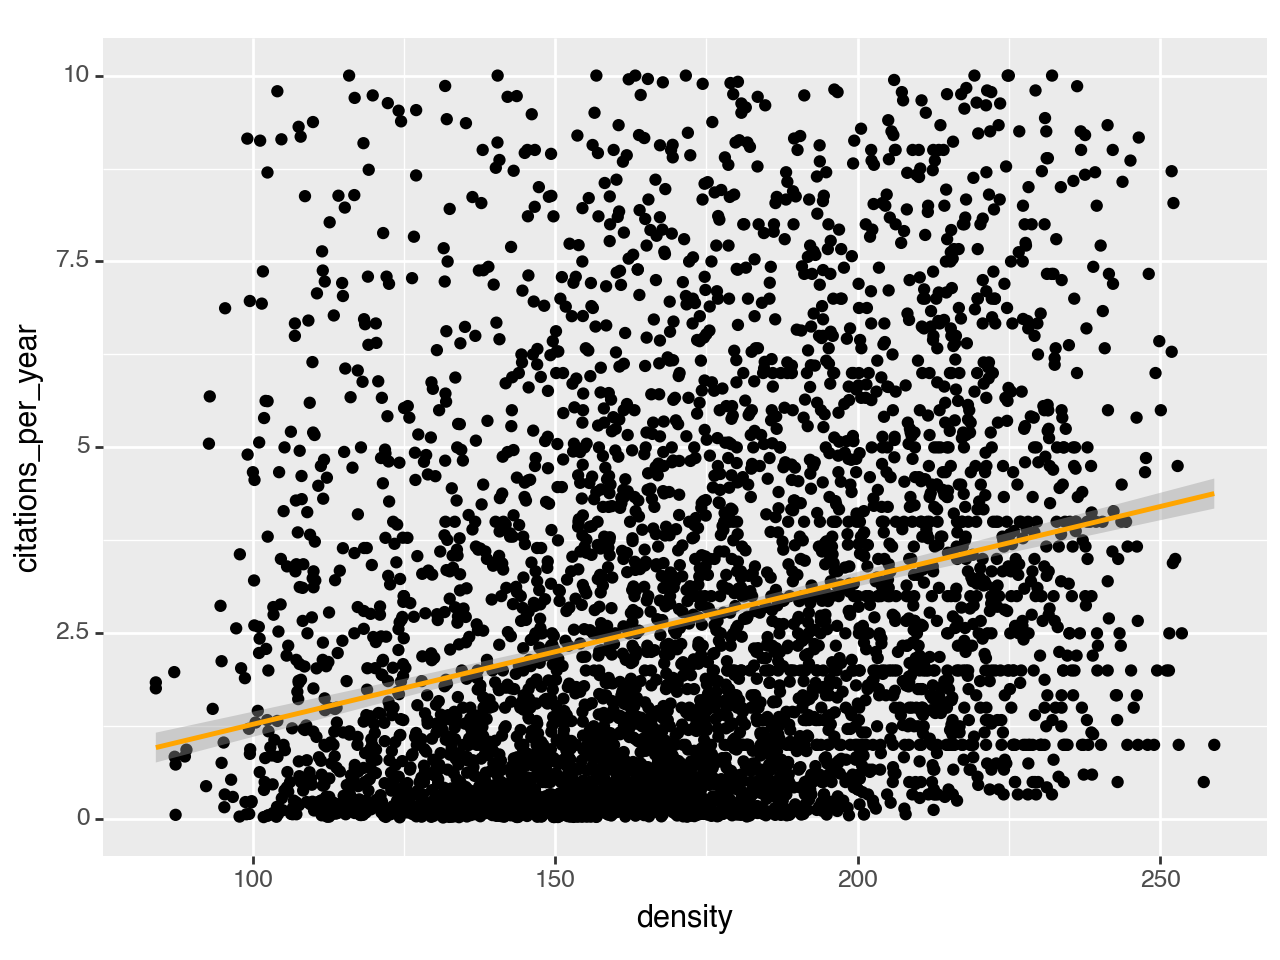

<Figure Size: (640 x 480)>

In [178]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point()
    + pn.geom_smooth(color="orange")
)